In [1]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from datasets import load_from_disk
from scipy.stats import entropy, gmean
import pandas as pd
pd.set_option('max_colwidth', 400)

In [31]:
ds = load_from_disk("var/gsm8k_logprobs_answered")
ds = ds.remove_columns(
    [
        "length",
        "min",
        "mean",
        "gmean",
        "entropy",
        "n_min",
        "n_mean",
        "n_gmean",
        "n_entropy",
    ]
)
ds

DatasetDict({
    train: Dataset({
        features: ['question', 'answer', 'reasoning', 'logprobs', 'id'],
        num_rows: 7473
    })
    test: Dataset({
        features: ['question', 'answer', 'reasoning', 'logprobs', 'id', 'generated_probs', 'generated_text', 'generated_tokens', 'gen_answer'],
        num_rows: 1319
    })
    cot: Dataset({
        features: ['question', 'reasoning', 'answer', 'logprobs', 'id'],
        num_rows: 8
    })
})

In [32]:
def normalize(arr):
    # normalizes a list of probabilities
    # to sum to 1
    return arr / arr.sum(0)

def last_tokens(tokens, probs):
    answer_tokens, answer_probs = [], []
    tokens, probs = reversed(tokens), reversed(probs)
    zipper = zip(tokens, probs, strict=True)
    for i, (token, prob) in enumerate(zipper):
        if "Ġ" in token:
            if "-" in token:
                answer_tokens.append("-") #token.partition("-")[2])
                answer_probs.append(prob)
            break
        else:
            answer_tokens.append(token)
            answer_probs.append(prob)
    return list(reversed(answer_tokens)), list(reversed(answer_probs))

def mapper(row):
    input_logprobs = np.array(row["logprobs"]).astype(float)
    input_probs = np.exp(input_logprobs[1:]) # drop the first token
    input_probs_normalized = normalize(input_probs)

    generated_probs = np.array(row["generated_probs"]).astype(float)

    generated_tokens = row["generated_tokens"]
    if generated_tokens[-1] == "<|endoftext|>":
        generated_tokens = generated_tokens[:-1]
        generated_probs = generated_probs[:-1]

    generated_probs_normalized = normalize(generated_probs)

    correct = row["answer"] == row["gen_answer"]
    last_toks, last_probs = last_tokens(generated_tokens, generated_probs)
    if len(last_probs) != len(last_toks):
        raise ValueError("uh oh")
    
    if len(last_toks) == 0:
        last_toks = [""]
        last_probs = [0]
        
    tok_answer = "".join(last_toks).replace(",", "").replace("$", "")
    float_tok = None
    try:
        float_tok = float(tok_answer)
    except ValueError:
        pass

    return {
        "correct": correct,
        "input_length": input_logprobs.shape[0],
        "input_min": np.min(input_probs),
        "input_mean": np.mean(input_probs),
        "input_gmean": gmean(input_probs),
        "input_entropy": entropy(input_probs),
        "input_min_norm": np.min(input_probs_normalized),
        "input_mean_norm": np.mean(input_probs_normalized),
        "input_gmean_norm": gmean(input_probs_normalized),
        "input_entropy_norm": entropy(input_probs_normalized),
        # generated
        "generated_length": generated_probs.shape[0],
        "generated_min": np.min(generated_probs),
        "generated_mean": np.mean(generated_probs),
        "generated_gmean": gmean(generated_probs),
        "generated_entropy": entropy(generated_probs),
        "generated_min_norm": np.min(generated_probs_normalized),
        "generated_mean_norm": np.mean(generated_probs_normalized),
        "generated_gmean_norm": gmean(generated_probs_normalized),
        "generated_entropy_norm": entropy(generated_probs_normalized),
        "answerprob_gmean": gmean(last_probs),
        "answerprob_first": last_probs[0],
        "last_toks": last_toks,
        "last_probs": last_probs,
        "tok_answer": tok_answer,
        "answer_toks": row["answer"] == float_tok,
    }
ds["test"] = ds["test"].map(mapper)#, num_proc=64)

Map:   0%|          | 0/1319 [00:00<?, ? examples/s]

In [15]:
# for split in ds.keys():
#     ds[split] = ds[split].add_column("id", list(range(len(ds[split]))))
# ds.save_to_disk("gsm8k_logprobs_agg")

In [100]:
df = ds["test"].to_pandas()
df["correct"].mean()

0.18043972706595907

In [36]:
df[(df["correct"] == False)][["gen_answer", "last_toks", "tok_answer", "last_probs", "answerprob_gmean", "answerprob_first"]]

,gen_answer,last_toks,tok_answer,last_probs,answerprob_gmean,answerprob_first
0,10.0,"[1, 0]",10,"[0.999995112442896, 0.9999891520726072]",0.999992,0.999995
1,8.0,[8],8,[0.9999995231630692],1.000000,1.000000
2,50000.0,"[5, 0, 0, 0, 0]",50000,"[0.9999994039539004, 0.9999986886995842, 0.9999974966112362, 0.9999996423722521, 0.9999990463265931]",0.999999,0.999999
3,720.0,"[7, 2, 0]",720,"[0.9998732965854205, 0.999768668291261, 0.9999322937076363]",0.999858,0.999873
4,540.0,"[5, 4, 0]",540,"[0.9999995231630692, 0.9999988079084972, 0.9999984502816872]",0.999999,1.000000
...,...,...,...,...,...,...
1313,5.6,"[5, ., 6]",5.6,"[0.999993205116773, 0.9999997615814777, 0.9999994039539004]",0.999997,0.999993
1314,23.0,"[2, 3]",23,"[0.9999933243243502, 0.9999302674272115]",0.999962,0.999993
1316,455.0,"[4, 5, 5]",455,"[0.9999979734461775, 0.9999985694905718, 0.9999976158197796]",0.999998,0.999998
1317,10.0,"[1, 0]",10,"[0.9975264612255361, 0.9995697204897156]",0.998548,0.997526


In [44]:
pretty_names = {
    "correct": "Correct",
    "input_length": "Input length",
    "input_min": "Input min",
    "input_mean": "Input arith. mean",
    "input_gmean": "Input geo. mean",
    "input_entropy": "Input Entropy",
    "input_min_norm": "Input min (norm)",
    "input_mean_norm": "Input arith. mean (norm)",
    "input_gmean_norm": "Input geo. mean (norm)",
    "input_entropy_norm": "Input entropy (norm)",
    "generated_length": "Output length",
    "generated_min": "Output min",
    "generated_mean": "Output arith. mean",
    "generated_gmean": "Output geo. mean",
    "generated_entropy": "Output entropy",
    "generated_min_norm": "Output min (norm)",
    "generated_mean_norm": "Output arith. mean (norm)",
    "generated_gmean_norm": "Output geo. mean (norm)",
    "generated_entropy_norm": "Output entropy (norm)",
    "answerprob_gmean": "Answer geo. mean",
    "answerprob_first": "Answer first token",
}

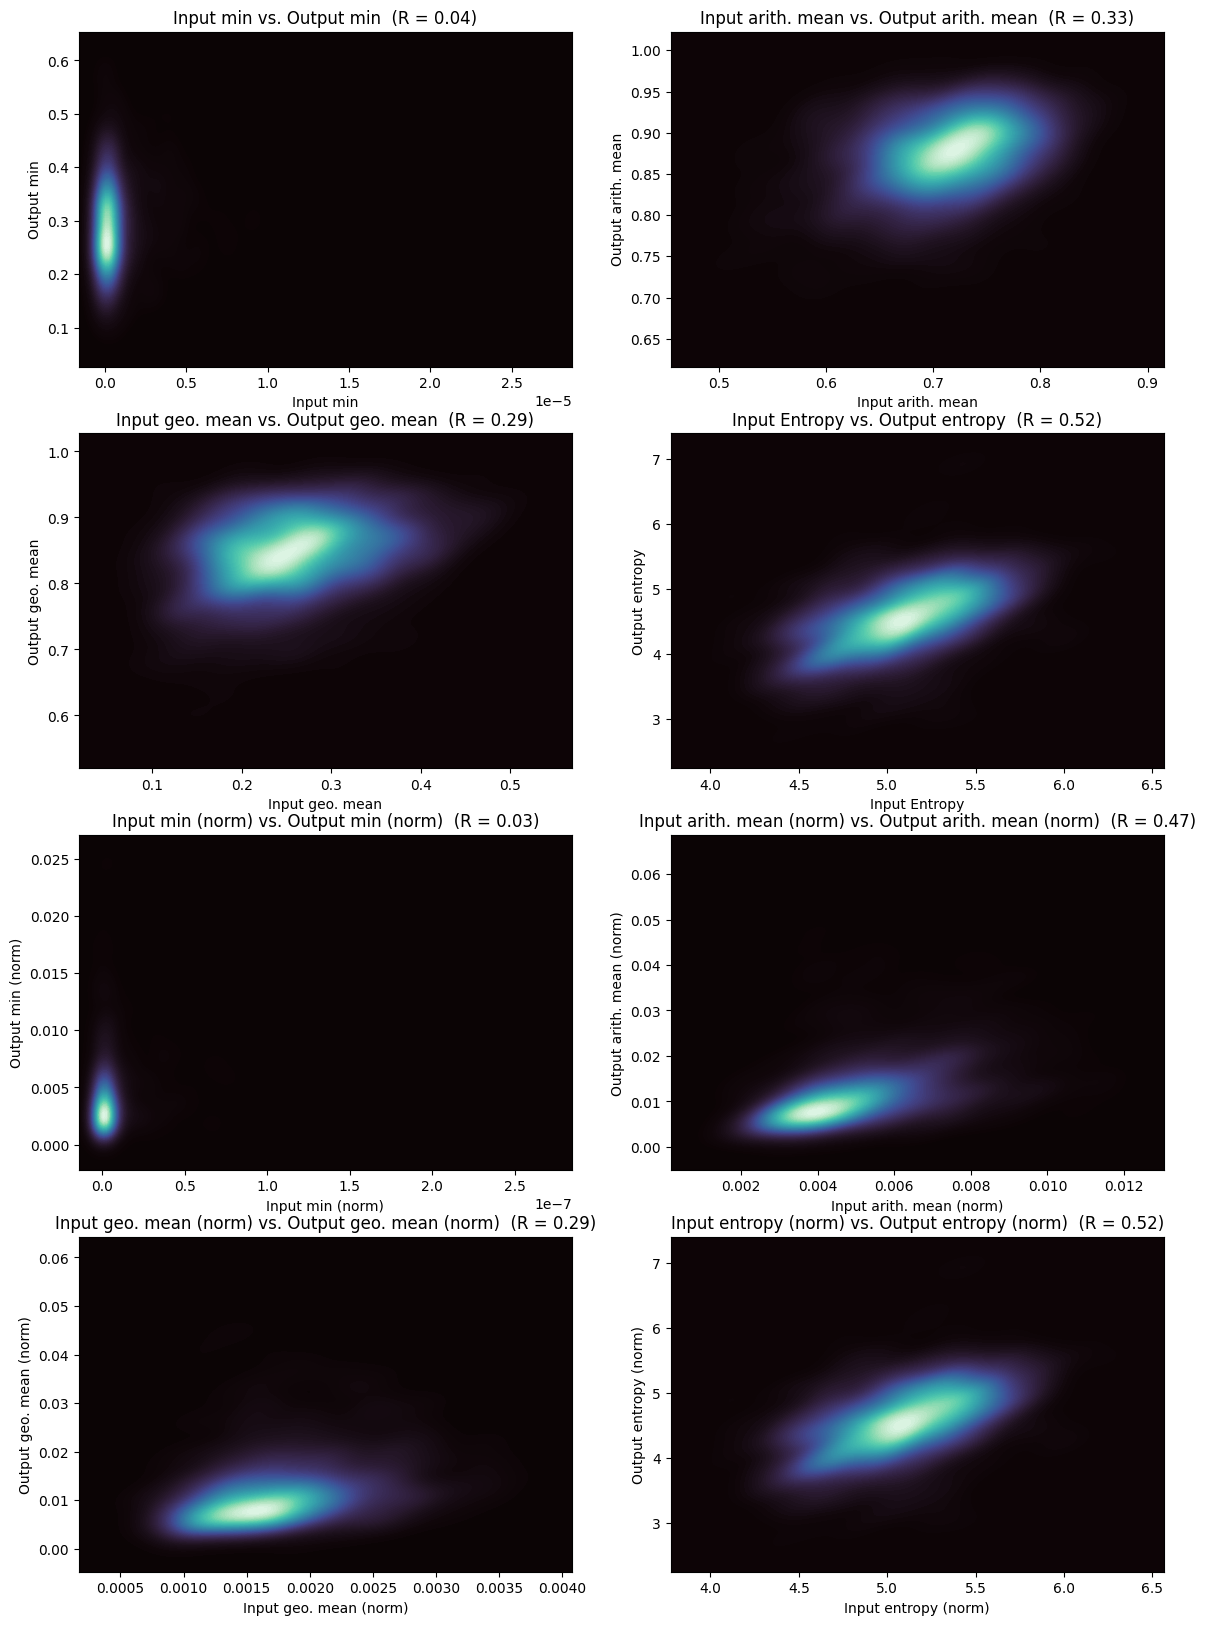

In [103]:
# Input sequence measures vs output sequence measures, no conditioning
fig, ax = plt.subplots(4, 2, sharex=False, figsize=(14, 20))
# fig.suptitle("Input sequence probability vs. Output sequence probability")
for i, f in enumerate(
    [
        "min",
        "mean",
        "gmean",
        "entropy",
        "min_norm",
        "mean_norm",
        "gmean_norm",
        "entropy_norm",
    ]
):
    x_col = f"input_{f}"
    y_col = f"generated_{f}"
    x_pretty = pretty_names[x_col]
    y_pretty = pretty_names[y_col]
    sct = sns.kdeplot(
        df,
        x=x_col,
        y=y_col,
        ax=ax[i // 2, i % 2],
        fill=True,
        thresh=0,
        levels=100,
        cmap="mako",
    )
    x = df[x_col].to_numpy()
    y = df[y_col].to_numpy()
    nas = np.logical_or(np.isnan(x), np.isnan(y))
    pears = pearsonr(x[~nas], y[~nas])
    sct.set(
        xlabel=x_pretty,
        ylabel=y_pretty,
        title=f"{x_pretty} vs. {y_pretty}  (R = {pears.statistic:.2f})",
    )

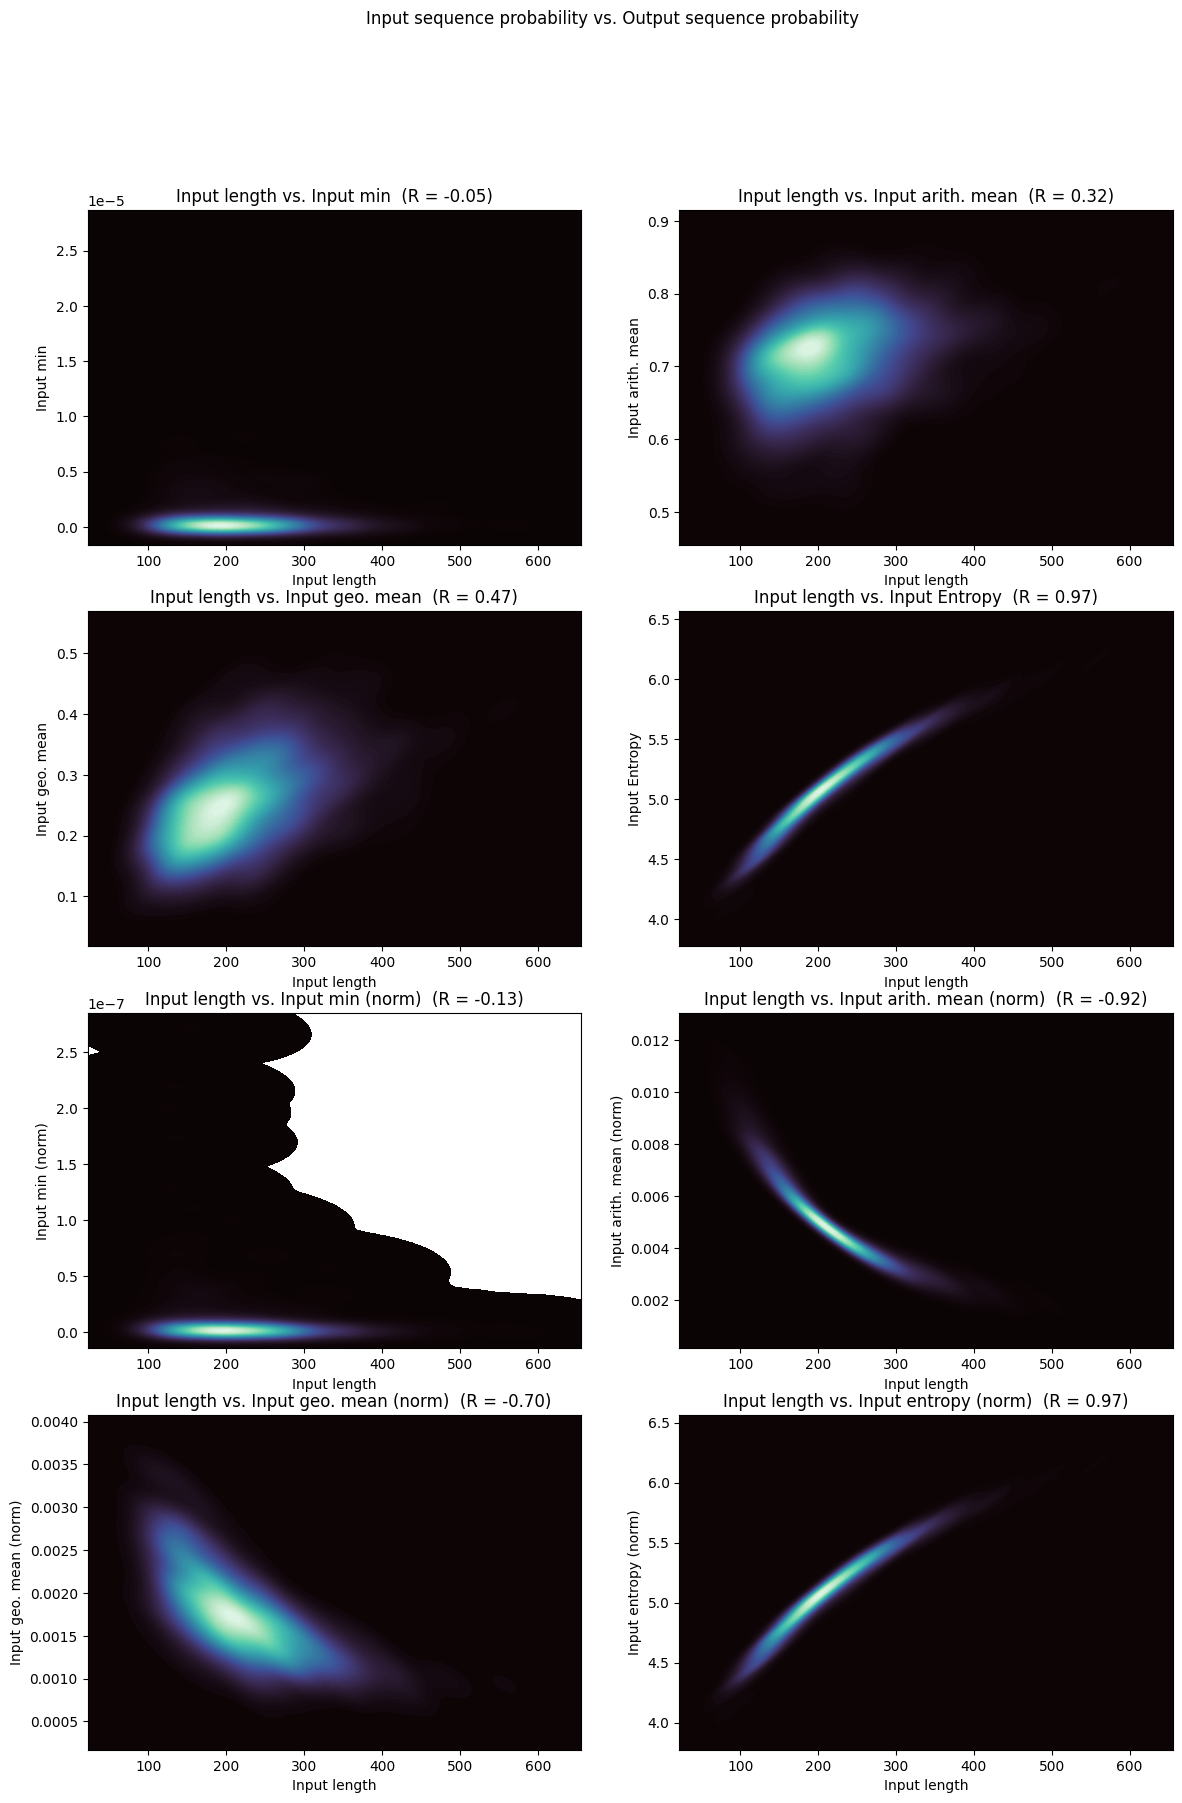

In [117]:
# Input sequence measures vs length, no conditioning
fig, ax = plt.subplots(4, 2, sharex=False, figsize=(14, 20))
# fig.suptitle("Input sequence probability vs. Output sequence probability")
for i, f in enumerate(
    [
        "min",
        "mean",
        "gmean",
        "entropy",
        "min_norm",
        "mean_norm",
        "gmean_norm",
        "entropy_norm",
    ]
):
    x_col = f"input_length"
    y_col = f"input_{f}"
    x_pretty = pretty_names[x_col]
    y_pretty = pretty_names[y_col]
    sct = sns.kdeplot(
        df,
        x=x_col,
        y=y_col,
        ax=ax[i // 2, i % 2],
        fill=True,
        thresh=0,
        levels=100,
        cmap="mako",
    )
    x = df[x_col].to_numpy()
    y = df[y_col].to_numpy()
    nas = np.logical_or(np.isnan(x), np.isnan(y))
    pears = pearsonr(x[~nas], y[~nas])
    sct.set(
        xlabel=x_pretty,
        ylabel=y_pretty,
        title=f"{x_pretty} vs. {y_pretty}  (R = {pears.statistic:.2f})",
    )

In [ ]:
# NORMALIZATION Playground
# Input sequence measures vs answer measures, no conditioning
fig, ax = plt.subplots(4, 2, sharex=False, figsize=(14, 20))
fig.suptitle("Input sequence probability vs. Output sequence probability")
df_min_max_scaled = df.copy()
df_z_scaled = df.copy()
column = "answerprob_first"
cols = [column]#'col_1', 'col_2'] # one or more

Q1 = df_min_max_scaled[cols].quantile(0.25)
Q3 = df_min_max_scaled[cols].quantile(0.75)
IQR = Q3 - Q1

df_min_max_scaled = df_min_max_scaled[~((df_min_max_scaled[cols] < (Q1 - 1.5 * IQR)) |(df_min_max_scaled[cols] > (Q3 + 1.5 * IQR))).any(axis=1)]
df_min_max_scaled[column] = (df_min_max_scaled[column] - df_min_max_scaled[column].min()) / (df_min_max_scaled[column].max() - df_min_max_scaled[column].min()) 
df_z_scaled[column] = (df_z_scaled[column] - df_z_scaled[column].mean()) / df_z_scaled[column].std()
for i, f in enumerate(
    [
        "min",
        "mean",
        "gmean",
        "entropy",
        "min_norm",
        "mean_norm",
        "gmean_norm",
        "entropy_norm",
    ]
):
    x_col = f"input_{f}"
    y_col = f"answerprob_first"
    x_pretty = pretty_names[x_col]
    y_pretty = pretty_names[y_col]
    column = x_col
    df_min_max_scaled[column] = (df_min_max_scaled[column] - df_min_max_scaled[column].min()) / (df_min_max_scaled[column].max() - df_min_max_scaled[column].min())  
    df_z_scaled[column] = (df_z_scaled[column] - df_z_scaled[column].mean()) / df_z_scaled[column].std()

    sct = sns.kdeplot(
        df_min_max_scaled,
        x=x_col,
        y=y_col,
        ax=ax[i // 2, i % 2],
        fill=True,
        thresh=0,
        levels=100,
        cmap="mako",
    )
    x = df_min_max_scaled[x_col].to_numpy()
    y = df_min_max_scaled[y_col].to_numpy()
    nas = np.logical_or(np.isnan(x), np.isnan(y))
    pears = pearsonr(x[~nas], y[~nas])
    sct.set(
        xlabel=x_pretty,
        ylabel=y_pretty,
        title=f"{x_pretty} vs. {y_pretty}  (R = {pears.statistic:.2f})",
    )

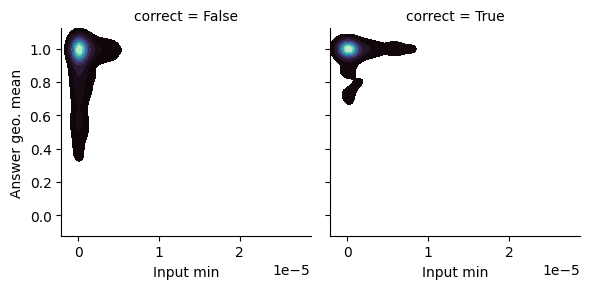

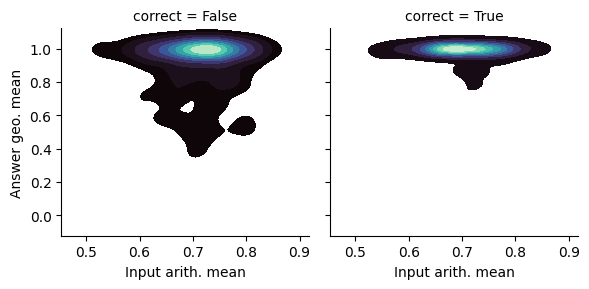

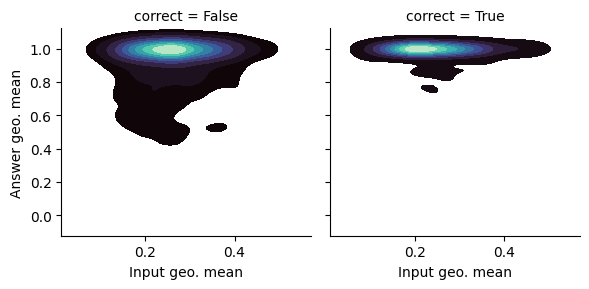

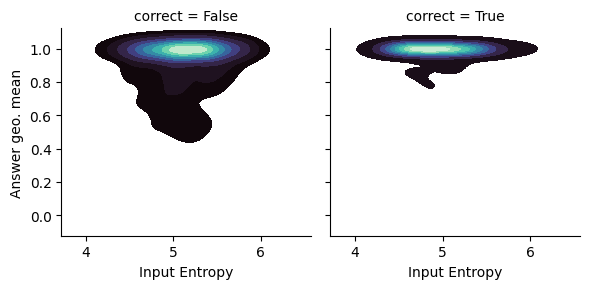

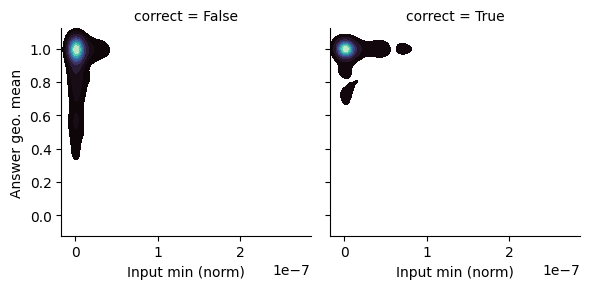

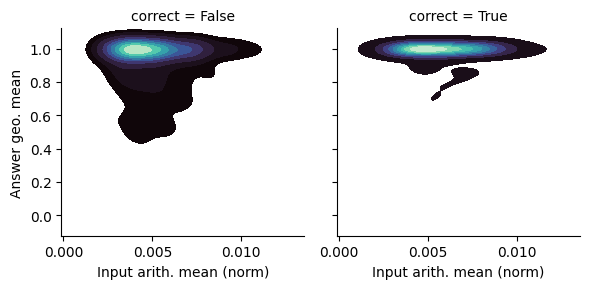

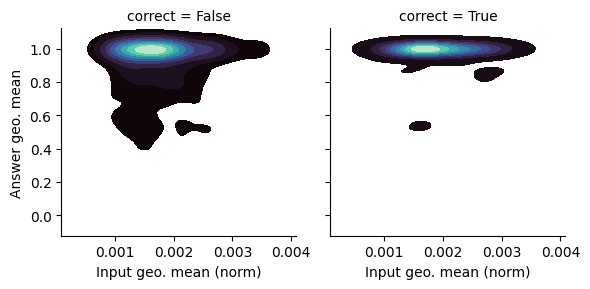

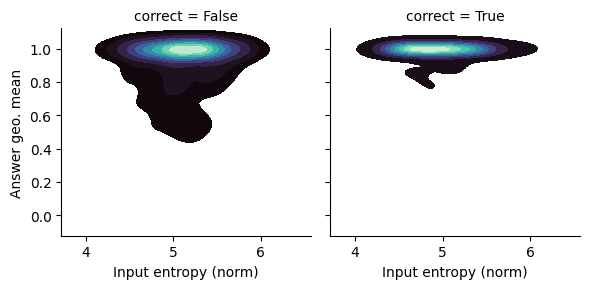

In [54]:
# Input sequence measures vs answer token probability, conditioned on correctness
for i, f in enumerate(
    [
        "min",
        "mean",
        "gmean",
        "entropy",
        "min_norm",
        "mean_norm",
        "gmean_norm",
        "entropy_norm",
    ]
):
    x_col = f"input_{f}"
    y_col = "answerprob_first"
    x_pretty = pretty_names[x_col]
    y_pretty = pretty_names[y_col]
    g = sns.FacetGrid(df, col="correct")
    g.map_dataframe(sns.kdeplot, x=x_col, y=y_col, fill=True, cmap="mako")
    g.set_xlabels(x_pretty)
    g.set_ylabels(y_pretty)
    plt.show()

In [69]:
df[df["correct"] == True].shape

(238, 34)

In [71]:
df_resampled = df[df["correct"] == True]
df_sample = df[df["correct"] == False].sample(n=len(df_resampled))
df_resampled = pd.concat([df_resampled, df_sample])

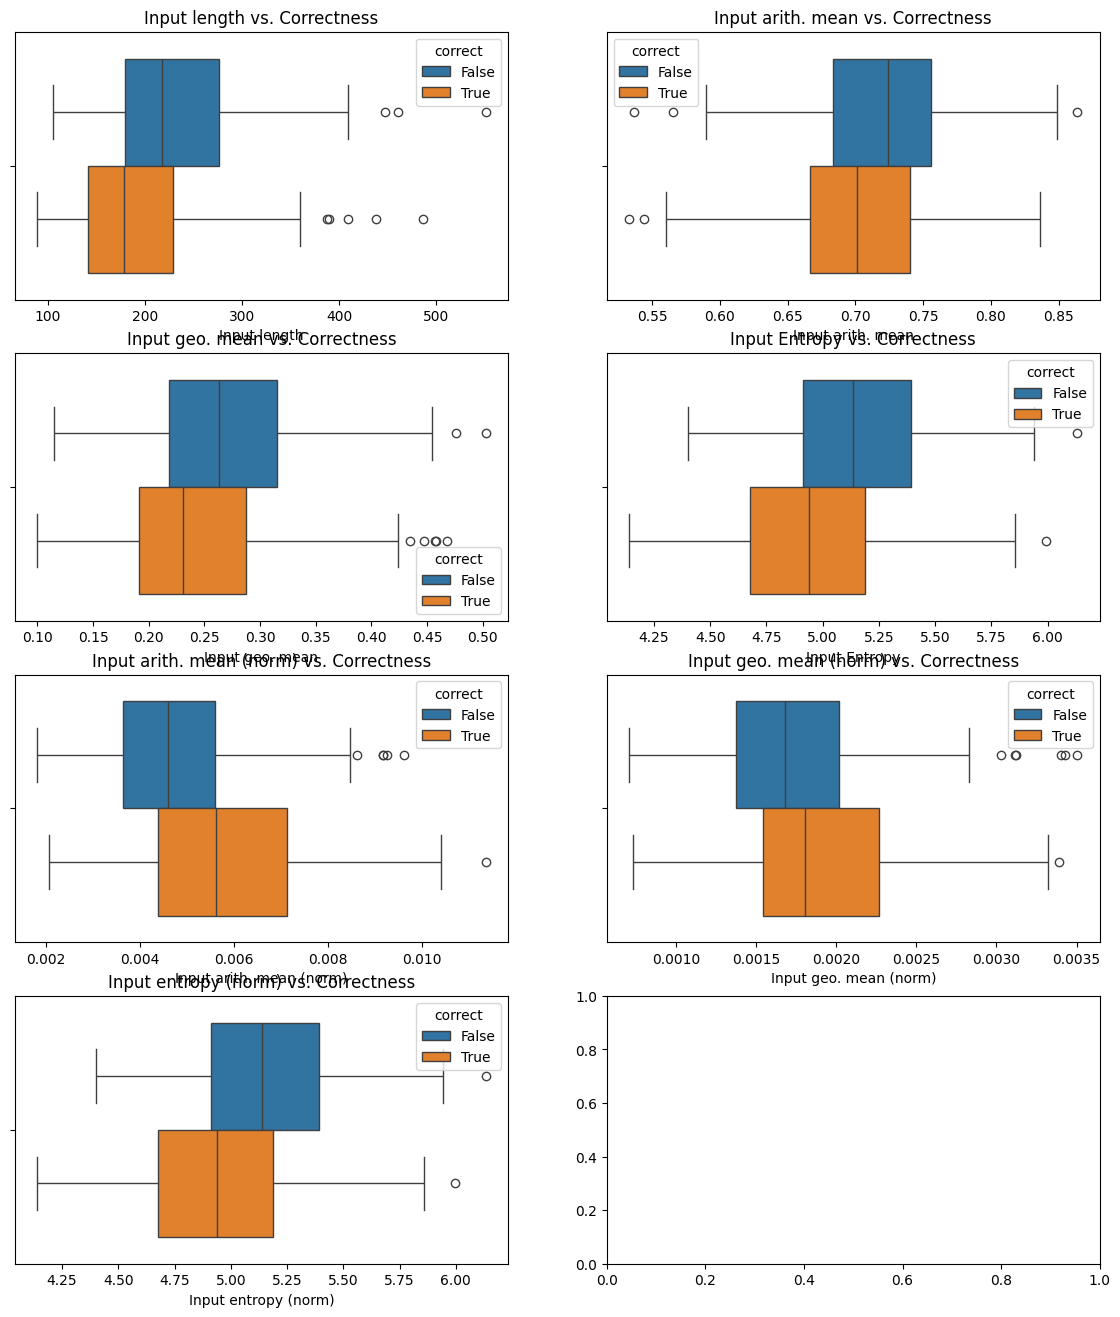

In [119]:
# Input sequence measures, conditioned on correctness (boxplot)
fig, ax = plt.subplots(4, 2, sharex=False, figsize=(14, 16))
for i, f in enumerate(
    [
        "length",
        # "min",
        "mean",
        "gmean",
        "entropy",
        # "min_norm",
        "mean_norm",
        "gmean_norm",
        "entropy_norm",
    ]
):
    x_col = f"input_{f}"
    y_col = "answerprob_first"
    x_pretty = pretty_names[x_col]
    y_pretty = pretty_names[y_col]
    g = sns.boxplot(df_resampled, x=x_col, hue="correct", ax=ax[i // 2, i % 2])
    g.set_xlabel(x_pretty)
    g.set_title(f"{x_pretty} vs. Correctness")
    # plt.show()

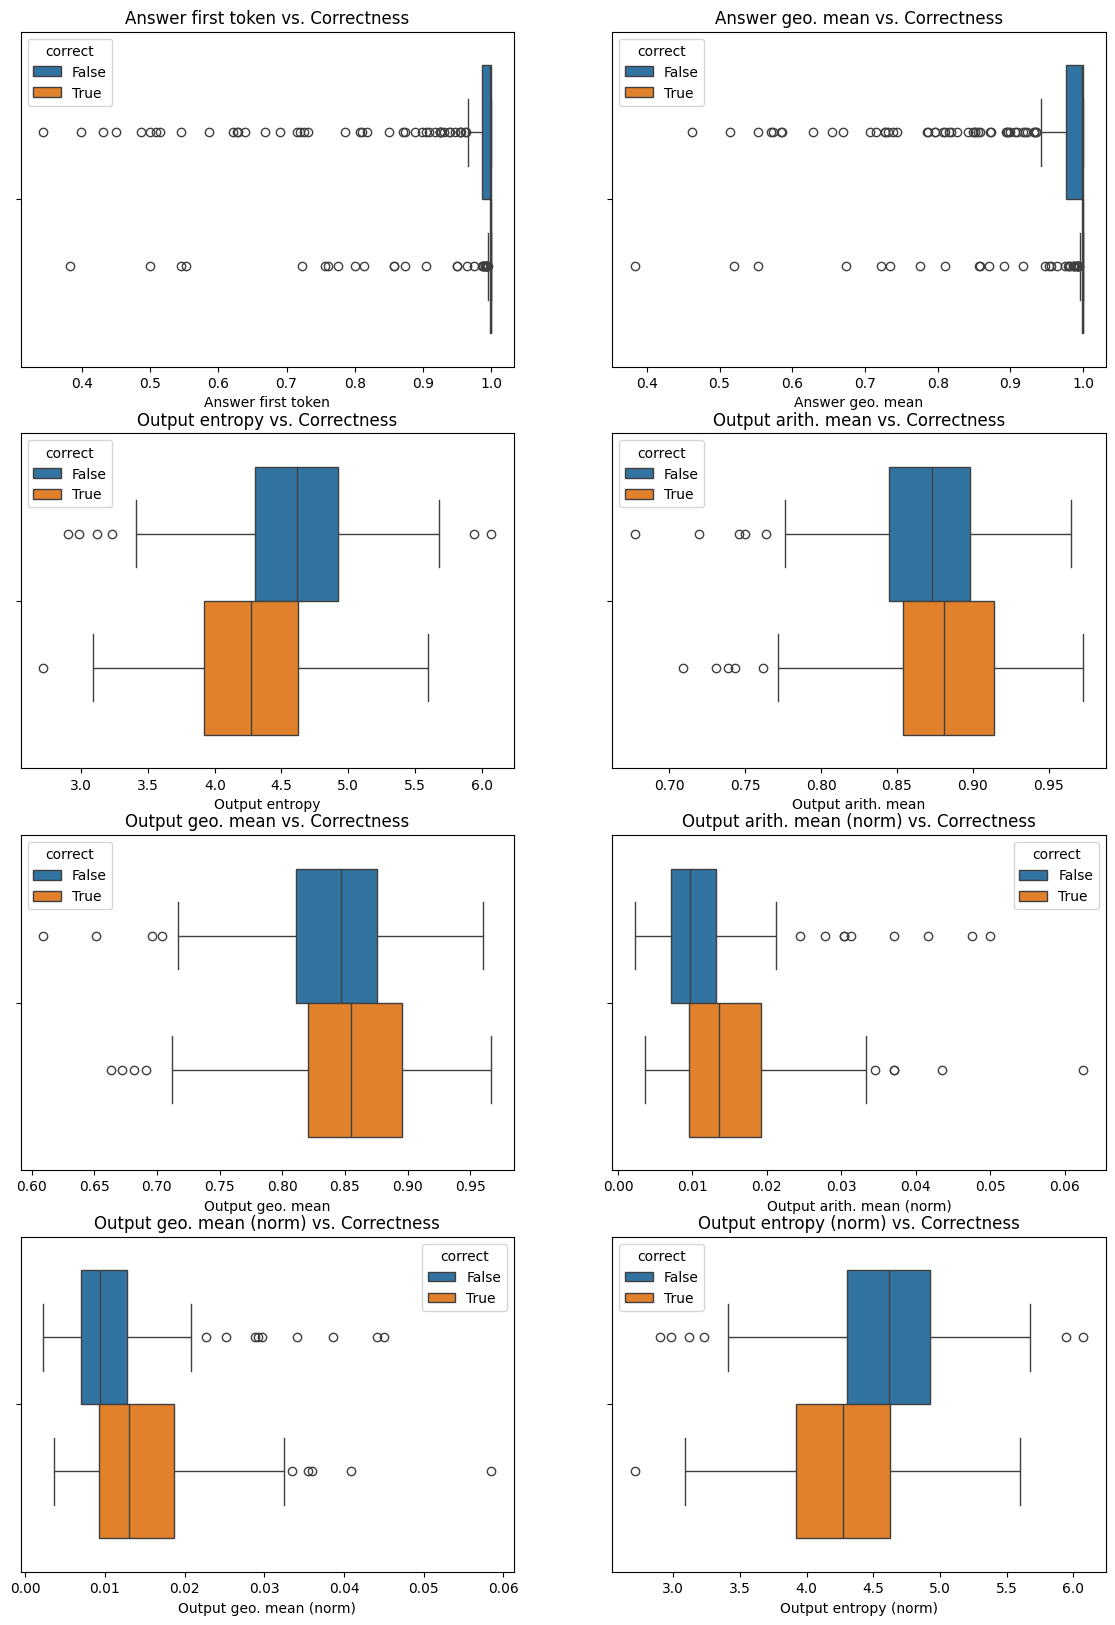

In [116]:
# Input sequence measures, conditioned on correctness (boxplot)
fig, ax = plt.subplots(4, 2, sharex=False, figsize=(14, 20))
for i, x_col in enumerate(
    [
        "answerprob_first",
        "answerprob_gmean",
        "generated_entropy",
        "generated_mean",
        "generated_gmean",
        "generated_mean_norm",
        "generated_gmean_norm",
        "generated_entropy_norm",
    ]
):
    x_pretty = pretty_names[x_col]
    g = sns.boxplot(df_resampled, x=x_col, hue="correct", ax=ax[i // 2, i % 2])
    g.set_xlabel(x_pretty)
    g.set_title(f"{x_pretty} vs. Correctness")
    # plt.show()

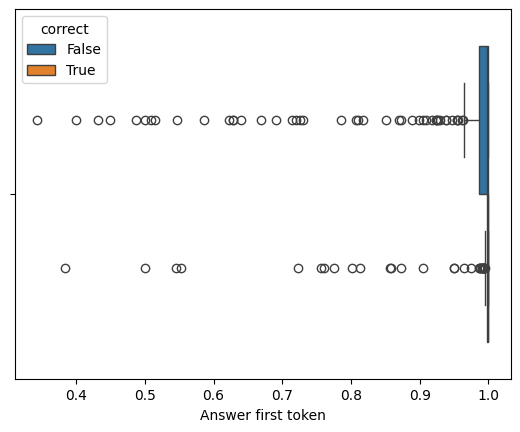

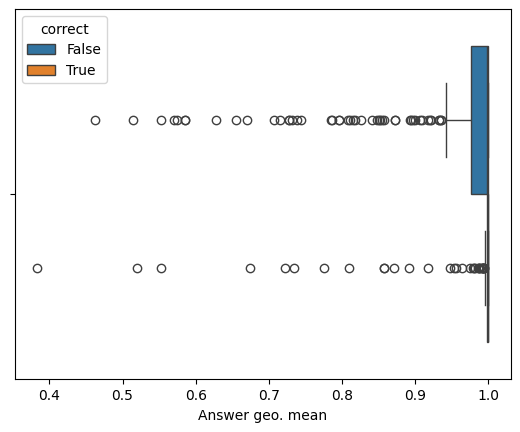

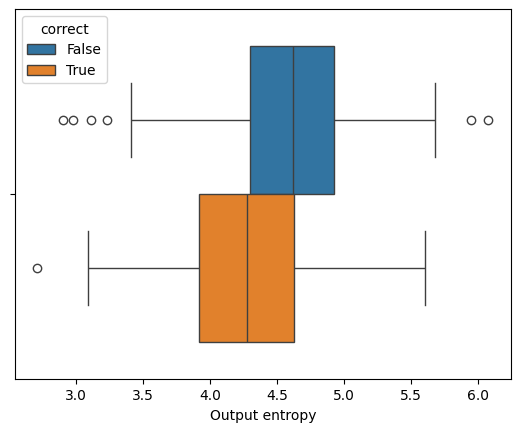

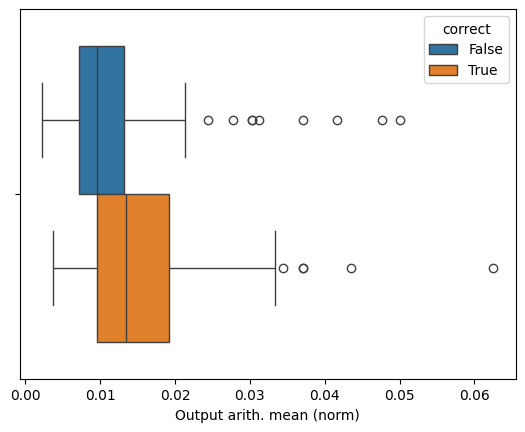

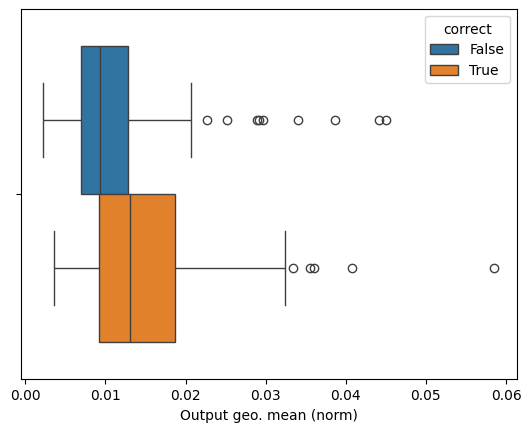

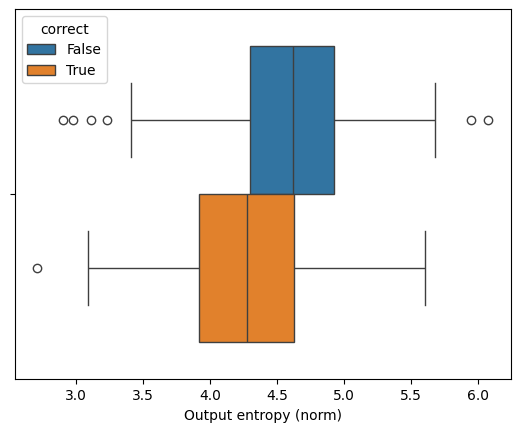

In [87]:
# Input sequence measures, conditioned on correctness (boxplot)
for i, x_col in enumerate(
    [
        # "min",
        "answerprob_first",
        "answerprob_gmean",
        "generated_entropy",
        "generated_mean_norm",
        "generated_gmean_norm",
        "generated_entropy_norm",
    ]
):
    x_pretty = pretty_names[x_col]
    g = sns.boxplot(df_resampled, x=x_col, hue="correct")
    g.set_xlabel(x_pretty)
    plt.show()

In [96]:
accuracies = [0.2, 0.6, 0.5, 0.1, 0.6, 0.5]
Shape = [1201, 1006, 1052, 1320, 1035, 1085]
Min = [1.457069651341291e-10, 1.8953799122906976e-08, 3.7910417027920744e-09, 1.864730767869872e-09, 2.375997203841347e-08, 6.03443771536222e-09]
Max = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Mean = [0.8787593422585893, 0.8725241907968498, 0.8835834288087651, 0.8682737015211405, 0.8780507058633462, 0.8742235579549197]
Gmean = [0.6351220025377092, 0.6333854582304509, 0.6371673435270344, 0.6319605699164628, 0.6076227822783787, 0.635646220311767]
Entropy = [7.010786282622528, 6.830101292632026, 6.884857657533949, 7.101693645521822, 6.857150552954218, 6.913037103494054]

norm_Shape = [1201, 1006, 1052, 1320, 1035, 1085]
norm_Min = [1.3805983500759617e-13, 2.1593389379987595e-11, 4.078451101777799e-12, 1.6269925274357134e-12, 2.6144839437869086e-11, 6.36186670591233e-12]
norm_Max = [0.0009475170585051069, 0.0011392644419181634, 0.0010758127769404514, 0.0008725080078419401, 0.0011003733251705823, 0.001054260066305193]
norm_Mean = [0.0008326394671107411, 0.0009940357852882703, 0.0009505703422053232, 0.0007575757575757576, 0.000966183574879227, 0.0009216589861751152]
norm_Gmean = [0.0006017889316364034, 0.0007215935305899968, 0.0006854727692155889, 0.0005513906578924701, 0.0006686119013850608, 0.0006701364263725282]
norm_Entropy = [7.010786282622528, 6.830101292632026, 6.884857657533949, 7.101693645521822, 6.857150552954218, 6.913037103494054]

accuracies.extend([0.3, 0.3, 0.0, 0.1, 0.3, 0.2, 0.7, 0.6, 0.2, 0.2, 0.5, 0.2])
Shape.extend([822, 700, 797, 577, 618, 621, 698, 571, 527, 503, 618, 699])
Min.extend([5.44772066433229e-09, 6.041972880252352e-08, 8.186175436293087e-07, 1.0488951526307312e-07, 1.8699130612862024e-07, 1.9941154127118333e-08, 4.0046212578606606e-08, 3.4320765465946254e-08, 8.298330442472104e-06, 2.46650636028206e-07, 3.9278597995802437e-07, 2.174191589888458e-06])
Max.extend([1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0])
Mean.extend([0.8781214534694503, 0.8696521073966857, 0.8529587365822683, 0.854456167785778, 0.8778267025937906, 0.8737227634919129, 0.8548697524354367, 0.8504120757702417, 0.8249757003593129, 0.8646864905450099, 0.8566803627743683, 0.8778075071034118])
Gmean.extend([0.5933160802150108, 0.5755346147073249, 0.5283880368460094, 0.5293848636496068, 0.6249706201311415, 0.5543571810776456, 0.5381055907487919, 0.5601416061342144, 0.5295596733927477, 0.5439971991836662, 0.5407672545070025, 0.5905375349171156])
Entropy.extend([6.623200487101165, 6.460492180486299, 6.573813296073874, 6.251608823460343, 6.344575794232899, 6.3415040765386665, 6.44134592030967, 6.247851729002319, 6.151561242949837, 6.119336930866491, 6.324958068106857, 6.462292699565786])
norm_Min.extend([7.547244604580962e-12, 9.925106551825768e-11, 1.2041891350034424e-09, 2.1274848503117038e-10, 3.4468640349703194e-10, 3.6752343700640336e-11, 6.711291074120312e-11, 7.067916965490037e-11, 1.9087056223583517e-08, 5.670946900572323e-10, 7.419056709683812e-10, 3.5434094991186532e-09])
norm_Max.extend([0.0013853949329661532, 0.00164269299921307, 0.0014710033328441965, 0.0020283103082093237, 0.0018433284981706187, 0.0018430399497619933, 0.0016758865925077773, 0.0020593704334779376, 0.002300107998338207, 0.0022991819489668027, 0.0018888293086419888, 0.0016297595463058707])
norm_Mean.extend([0.0012165450121654502, 0.0014285714285714284, 0.0012547051442910915, 0.0017331022530329288, 0.0016181229773462784, 0.0016103059581320449, 0.0014326647564469911, 0.0017513134851138354, 0.0018975332068311194, 0.00198807157057654, 0.0016181229773462782, 0.0014306151645207437])
norm_Gmean.extend([0.000821977091177215, 0.0009454266823845131, 0.0007772605632354837, 0.0010737567759504848, 0.0011520261546070964, 0.0010217024311635447, 0.0009018039448893783, 0.001153539062233645, 0.0012180444403680271, 0.0012507485406515837, 0.0010214170394666894, 0.0009624341849831058])
norm_Entropy.extend([6.623200487101165, 6.4604921804863, 6.573813296073874, 6.251608823460343, 6.344575794232899, 6.341504076538668, 6.441345920309672, 6.247851729002319, 6.151561242949838, 6.119336930866492, 6.324958068106858, 6.462292699565786])

accuracies.extend([0.2, 0.4, 0.7, 0.6, 0.5, 0.7, 0.3, 0.5, 0.2, 0.6, 0.4, 0.7])
Shape.extend([1175, 1032, 936, 1553, 1416, 1159, 1160, 1263, 828, 1111, 979, 1132])
Min.extend([6.015407979923643e-07, 1.0694577748042132e-08, 2.1319446720417144e-07, 4.270609966834033e-09, 2.089822981531493e-08, 4.56461046329604e-08, 3.725519375984045e-08, 3.84950429225241e-11, 4.271271979988811e-08, 2.760712718080897e-07, 1.0273327076232076e-08, 3.7186526838357505e-07])
Mean.extend([0.811573925497204, 0.8548342247639477, 0.8691704477368115, 0.8759623055707602, 0.8871049363025263, 0.8628379910020363, 0.8598468224325972, 0.8716569327621221, 0.8709052056870351, 0.8649638427517061, 0.8546417694283159, 0.8526574578862998])
Gmean.extend([0.5056547552580676, 0.6232732682221567, 0.6096680629946735, 0.6405114822563528, 0.6742941522895456, 0.6187322961058885, 0.6180249502654956, 0.6434683667787633, 0.5923450227459545, 0.603523741456698, 0.5668017545430423, 0.5968094081125358])
Entropy.extend([6.938110054210833, 6.845478894986773, 6.753589156581524, 7.2655687128113575, 7.183850230164881, 6.964922557326569, 6.964580333300628, 7.059832808271526, 6.632177847518471, 6.921939422517028, 6.785417836508678, 6.93332529306569])
norm_Min.extend([6.308108223154271e-10, 1.2122774959099189e-11, 2.6205661647172527e-10, 3.139301557904021e-12, 1.6636855766733466e-11, 4.5644770364598277e-11, 3.735147413097248e-11, 3.4966798346462696e-14, 5.923194631227846e-11, 2.8728252123940387e-10, 1.2278471564991797e-11, 3.852694704377376e-10])
norm_Max.extend([0.0010486584192140437, 0.0011335440486482525, 0.0012291905128136353, 0.0007350944203015818, 0.0007960892340528007, 0.0009999707692830999, 0.0010025843476147967, 0.0009083454827375455, 0.001386751922841346, 0.0010406099821900616, 0.0011951796602873413, 0.001036045856372734])
norm_Mean.extend([0.000851063829787234, 0.0009689922480620154, 0.0010683760683760685, 0.000643915003219575, 0.0007062146892655367, 0.0008628127696289905, 0.0008620689655172414, 0.000791765637371338, 0.0012077294685990338, 0.0009000900090008999, 0.0010214504596527069, 0.0008833922261484099])
norm_Gmean.extend([0.0005302591163169886, 0.0007065077038747704, 0.0007493981989985183, 0.00047083641674574087, 0.0005367983152224675, 0.0006187142101173044, 0.0006196221415715996, 0.0005844915842479952, 0.0008214355992784546, 0.0006280328298485338, 0.0006774299284450228, 0.000618321914319258])
norm_Entropy.extend([6.938110054210833, 6.845478894986774, 6.753589156581524, 7.2655687128113575, 7.183850230164881, 6.964922557326569, 6.964580333300628, 7.059832808271526, 6.632177847518471, 6.921939422517029, 6.785417836508678, 6.93332529306569])

accuracies.extend([0.4, 0.2, 0.4, 0.3, 0.4, 0.5, 0.2, 0.4, 0.5, 0.6, 0.4, 0.3])
Shape.extend([791, 869, 1022, 937, 928, 903, 954, 915, 945, 860, 993, 852])
Min.extend([6.839733840590093e-07, 2.475239198902386e-07, 4.0608243918568774e-08, 1.0467361864851814e-08, 5.527352295717806e-08, 6.86463732017938e-09, 6.972726328818139e-09, 6.86463732017938e-09, 5.399362809786118e-08, 1.0467361864851814e-08, 5.0712065594860276e-08, 2.5207259605786527e-08])
Mean.extend([0.818389266719992, 0.785609992249171, 0.8464644501652456, 0.8463198704528864, 0.8146409145453452, 0.8104209167998694, 0.8160527778177865, 0.7704779635462408, 0.8089296576126632, 0.7764236249250875, 0.8093472888039988, 0.7969465709442075])
Gmean.extend([0.5331165301029376, 0.4743484450380281, 0.5552999669520136, 0.5541705979827293, 0.5137480529674286, 0.4878041549912046, 0.49391713911835083, 0.43696475715441635, 0.4998027576024576, 0.4495107702957434, 0.49582279451560474, 0.48257015784653917])
Entropy.extend([6.550658335954754, 6.622420378693223, 6.819855473074185, 6.732455535410769, 6.703908302744399, 6.669057492376188, 6.725064223184837, 6.650892018489904, 6.714555886957243, 6.596588327583626, 6.765134460827257, 6.601422014911907])
norm_Min.extend([1.0565809925096787e-09, 3.6256877478393737e-10, 4.694124348167092e-11, 1.3199671096730885e-11, 7.311440523273595e-11, 9.380353501489557e-12, 8.956451899025736e-12, 9.737249115494327e-12, 7.0631746347257e-11, 1.567617292275977e-11, 6.309967694778126e-11, 3.7124176866396654e-11])
norm_Max.extend([0.0015447691637347732, 0.0014647827771340804, 0.0011559535442064825, 0.0012610313149728632, 0.0013227744735825817, 0.0013664747406122888, 0.0012844978386730738, 0.0014184651950760135, 0.001308149662016413, 0.0014976240551498022, 0.00124427345263129, 0.0014727573503418238])
norm_Mean.extend([0.0012642225031605561, 0.001150747986191024, 0.0009784735812133072, 0.0010672358591248667, 0.0010775862068965517, 0.0011074197120708748, 0.0010482180293501047, 0.0010928961748633878, 0.001058201058201058, 0.0011627906976744186, 0.0010070493454179255, 0.0011737089201877932])
norm_Gmean.extend([0.0008235419763802987, 0.0006948174326520359, 0.0006419009648959217, 0.0006988264778934592, 0.0006795728103180663, 0.000666572056161203, 0.0006344354976811075, 0.0006198192994983807, 0.0006538168084325271, 0.0006731981426438223, 0.0006169391404252279, 0.0007107087470241054])
norm_Entropy.extend([6.550658335954754, 6.622420378693223, 6.819855473074185, 6.732455535410769, 6.703908302744399, 6.669057492376188, 6.725064223184839, 6.650892018489904, 6.714555886957244, 6.596588327583626, 6.765134460827257, 6.601422014911908])

In [ ]:
accuracies = [0.3, 0.3, 0.0, 0.1, 0.3, 0.2, 0.7, 0.6, 0.2, 0.2, 0.5, 0.2]
Shape = [822, 700, 797, 577, 618, 621, 698, 571, 527, 503, 618, 699]
Min = [5.44772066433229e-09, 6.041972880252352e-08, 8.186175436293087e-07, 1.0488951526307312e-07, 1.8699130612862024e-07, 1.9941154127118333e-08, 4.0046212578606606e-08, 3.4320765465946254e-08, 8.298330442472104e-06, 2.46650636028206e-07, 3.9278597995802437e-07, 2.174191589888458e-06]
Max = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Mean = [0.8781214534694503, 0.8696521073966857, 0.8529587365822683, 0.854456167785778, 0.8778267025937906, 0.8737227634919129, 0.8548697524354367, 0.8504120757702417, 0.8249757003593129, 0.8646864905450099, 0.8566803627743683, 0.8778075071034118]
Gmean = [0.5933160802150108, 0.5755346147073249, 0.5283880368460094, 0.5293848636496068, 0.6249706201311415, 0.5543571810776456, 0.5381055907487919, 0.5601416061342144, 0.5295596733927477, 0.5439971991836662, 0.5407672545070025, 0.5905375349171156]
Entropy = [6.623200487101165, 6.460492180486299, 6.573813296073874, 6.251608823460343, 6.344575794232899, 6.3415040765386665, 6.44134592030967, 6.247851729002319, 6.151561242949837, 6.119336930866491, 6.324958068106857, 6.462292699565786]
norm_Min = [7.547244604580962e-12, 9.925106551825768e-11, 1.2041891350034424e-09, 2.1274848503117038e-10, 3.4468640349703194e-10, 3.6752343700640336e-11, 6.711291074120312e-11, 7.067916965490037e-11, 1.9087056223583517e-08, 5.670946900572323e-10, 7.419056709683812e-10, 3.5434094991186532e-09]
norm_Max = [0.0013853949329661532, 0.00164269299921307, 0.0014710033328441965, 0.0020283103082093237, 0.0018433284981706187, 0.0018430399497619933, 0.0016758865925077773, 0.0020593704334779376, 0.002300107998338207, 0.0022991819489668027, 0.0018888293086419888, 0.0016297595463058707]
norm_Mean = [0.0012165450121654502, 0.0014285714285714284, 0.0012547051442910915, 0.0017331022530329288, 0.0016181229773462784, 0.0016103059581320449, 0.0014326647564469911, 0.0017513134851138354, 0.0018975332068311194, 0.00198807157057654, 0.0016181229773462782, 0.0014306151645207437]
norm_Gmean = [0.000821977091177215, 0.0009454266823845131, 0.0007772605632354837, 0.0010737567759504848, 0.0011520261546070964, 0.0010217024311635447, 0.0009018039448893783, 0.001153539062233645, 0.0012180444403680271, 0.0012507485406515837, 0.0010214170394666894, 0.0009624341849831058]
norm_Entropy = [6.623200487101165, 6.4604921804863, 6.573813296073874, 6.251608823460343, 6.344575794232899, 6.341504076538668, 6.441345920309672, 6.247851729002319, 6.151561242949838, 6.119336930866492, 6.324958068106858, 6.462292699565786]

In [ ]:
accuracies = [0.2, 0.4, 0.7, 0.6, 0.5, 0.7, 0.3, 0.5, 0.2, 0.6, 0.4, 0.7]
Shape = [1175, 1032, 936, 1553, 1416, 1159, 1160, 1263, 828, 1111, 979, 1132]
Min = [6.015407979923643e-07, 1.0694577748042132e-08, 2.1319446720417144e-07, 4.270609966834033e-09, 2.089822981531493e-08, 4.56461046329604e-08, 3.725519375984045e-08, 3.84950429225241e-11, 4.271271979988811e-08, 2.760712718080897e-07, 1.0273327076232076e-08, 3.7186526838357505e-07]
Mean = [0.811573925497204, 0.8548342247639477, 0.8691704477368115, 0.8759623055707602, 0.8871049363025263, 0.8628379910020363, 0.8598468224325972, 0.8716569327621221, 0.8709052056870351, 0.8649638427517061, 0.8546417694283159, 0.8526574578862998]
Gmean = [0.5056547552580676, 0.6232732682221567, 0.6096680629946735, 0.6405114822563528, 0.6742941522895456, 0.6187322961058885, 0.6180249502654956, 0.6434683667787633, 0.5923450227459545, 0.603523741456698, 0.5668017545430423, 0.5968094081125358]
Entropy = [6.938110054210833, 6.845478894986773, 6.753589156581524, 7.2655687128113575, 7.183850230164881, 6.964922557326569, 6.964580333300628, 7.059832808271526, 6.632177847518471, 6.921939422517028, 6.785417836508678, 6.93332529306569]
norm_Min = [6.308108223154271e-10, 1.2122774959099189e-11, 2.6205661647172527e-10, 3.139301557904021e-12, 1.6636855766733466e-11, 4.5644770364598277e-11, 3.735147413097248e-11, 3.4966798346462696e-14, 5.923194631227846e-11, 2.8728252123940387e-10, 1.2278471564991797e-11, 3.852694704377376e-10]
norm_Max = [0.0010486584192140437, 0.0011335440486482525, 0.0012291905128136353, 0.0007350944203015818, 0.0007960892340528007, 0.0009999707692830999, 0.0010025843476147967, 0.0009083454827375455, 0.001386751922841346, 0.0010406099821900616, 0.0011951796602873413, 0.001036045856372734]
norm_Mean = [0.000851063829787234, 0.0009689922480620154, 0.0010683760683760685, 0.000643915003219575, 0.0007062146892655367, 0.0008628127696289905, 0.0008620689655172414, 0.000791765637371338, 0.0012077294685990338, 0.0009000900090008999, 0.0010214504596527069, 0.0008833922261484099]
norm_Gmean = [0.0005302591163169886, 0.0007065077038747704, 0.0007493981989985183, 0.00047083641674574087, 0.0005367983152224675, 0.0006187142101173044, 0.0006196221415715996, 0.0005844915842479952, 0.0008214355992784546, 0.0006280328298485338, 0.0006774299284450228, 0.000618321914319258]
norm_Entropy = [6.938110054210833, 6.845478894986774, 6.753589156581524, 7.2655687128113575, 7.183850230164881, 6.964922557326569, 6.964580333300628, 7.059832808271526, 6.632177847518471, 6.921939422517029, 6.785417836508678, 6.93332529306569]

In [ ]:
accuracies = [0.4, 0.2, 0.4, 0.3, 0.4, 0.5, 0.2, 0.4, 0.5, 0.6, 0.4, 0.3]
Shape = [791, 869, 1022, 937, 928, 903, 954, 915, 945, 860, 993, 852]
Min = [6.839733840590093e-07, 2.475239198902386e-07, 4.0608243918568774e-08, 1.0467361864851814e-08, 5.527352295717806e-08, 6.86463732017938e-09, 6.972726328818139e-09, 6.86463732017938e-09, 5.399362809786118e-08, 1.0467361864851814e-08, 5.0712065594860276e-08, 2.5207259605786527e-08]
Mean = [0.818389266719992, 0.785609992249171, 0.8464644501652456, 0.8463198704528864, 0.8146409145453452, 0.8104209167998694, 0.8160527778177865, 0.7704779635462408, 0.8089296576126632, 0.7764236249250875, 0.8093472888039988, 0.7969465709442075]
Gmean = [0.5331165301029376, 0.4743484450380281, 0.5552999669520136, 0.5541705979827293, 0.5137480529674286, 0.4878041549912046, 0.49391713911835083, 0.43696475715441635, 0.4998027576024576, 0.4495107702957434, 0.49582279451560474, 0.48257015784653917]
Entropy = [6.550658335954754, 6.622420378693223, 6.819855473074185, 6.732455535410769, 6.703908302744399, 6.669057492376188, 6.725064223184837, 6.650892018489904, 6.714555886957243, 6.596588327583626, 6.765134460827257, 6.601422014911907]
norm_Min = [1.0565809925096787e-09, 3.6256877478393737e-10, 4.694124348167092e-11, 1.3199671096730885e-11, 7.311440523273595e-11, 9.380353501489557e-12, 8.956451899025736e-12, 9.737249115494327e-12, 7.0631746347257e-11, 1.567617292275977e-11, 6.309967694778126e-11, 3.7124176866396654e-11]
norm_Max = [0.0015447691637347732, 0.0014647827771340804, 0.0011559535442064825, 0.0012610313149728632, 0.0013227744735825817, 0.0013664747406122888, 0.0012844978386730738, 0.0014184651950760135, 0.001308149662016413, 0.0014976240551498022, 0.00124427345263129, 0.0014727573503418238]
norm_Mean = [0.0012642225031605561, 0.001150747986191024, 0.0009784735812133072, 0.0010672358591248667, 0.0010775862068965517, 0.0011074197120708748, 0.0010482180293501047, 0.0010928961748633878, 0.001058201058201058, 0.0011627906976744186, 0.0010070493454179255, 0.0011737089201877932]
norm_Gmean = [0.0008235419763802987, 0.0006948174326520359, 0.0006419009648959217, 0.0006988264778934592, 0.0006795728103180663, 0.000666572056161203, 0.0006344354976811075, 0.0006198192994983807, 0.0006538168084325271, 0.0006731981426438223, 0.0006169391404252279, 0.0007107087470241054]
norm_Entropy = [6.550658335954754, 6.622420378693223, 6.819855473074185, 6.732455535410769, 6.703908302744399, 6.669057492376188, 6.725064223184839, 6.650892018489904, 6.714555886957244, 6.596588327583626, 6.765134460827257, 6.601422014911908]

In [ ]:
accuracies = [0.7, 0.7, 0.7, 0.8, 0.7333333333333333, 0.7666666666666667, 0.7, 0.7, 0.7666666666666667, 0.7333333333333333]
Shape = [888, 888, 888, 888, 888, 888, 888, 888, 888, 888]
Min = [3.0835254884007364e-08, 1.7310674196374018e-08, 1.7310674196374018e-08, 5.4417105371561505e-08, 2.5207259605786527e-08, 2.372211592009424e-08, 3.2903236461716883e-07, 2.2235074245144013e-07, 5.4417105371561505e-08, 1.7310674196374018e-08]
Mean = [0.7216540054755203, 0.7133331674001636, 0.7117721367164799, 0.7176032187031386, 0.7125136979869148, 0.7213395838126926, 0.7206829454253229, 0.7220134933089145, 0.7128936555129561, 0.7127838335311358]
Gmean = [0.3778752946485591, 0.3567929696574198, 0.361512221324039, 0.3643536241804912, 0.3698280289176631, 0.38408695426294626, 0.3719315654601079, 0.3763808614198027, 0.368207212701019, 0.3665241135165111]
Entropy = [6.592313682950887, 6.581538600264022, 6.581797848545432, 6.586913117071376, 6.584180378235163, 6.59441477893695, 6.589360228492893, 6.592792122296737, 6.584139065628094, 6.5831503781213785]
norm_Min = [4.8117776478990017e-11, 2.7328047207509803e-11, 2.7387982006886576e-11, 8.539611092857232e-11, 3.984001106269437e-11, 3.703400604110945e-11, 5.141400174493874e-10, 3.468009705616075e-10, 8.596026012179884e-11, 2.734910860256292e-11]
norm_Mean = [0.0011261261261261261, 0.0011261261261261261, 0.0011261261261261261, 0.0011261261261261261, 0.0011261261261261261, 0.0011261261261261263, 0.0011261261261261261, 0.001126126126126126, 0.0011261261261261261, 0.001126126126126126]
norm_Gmean = [0.0005896665694260947, 0.0005632625862803174, 0.0005719644480956329, 0.000571775773358299, 0.0005845122791527834, 0.0005996209879590175, 0.0005811735322089943, 0.0005870421056485035, 0.0005816404155712979, 0.0005790709057490601]
norm_Entropy = [6.592313682950887, 6.581538600264022, 6.581797848545432, 6.586913117071376, 6.584180378235163, 6.594414778936949, 6.589360228492893, 6.592792122296737, 6.584139065628094, 6.583150378121379]

In [98]:
len(accuracies)

42

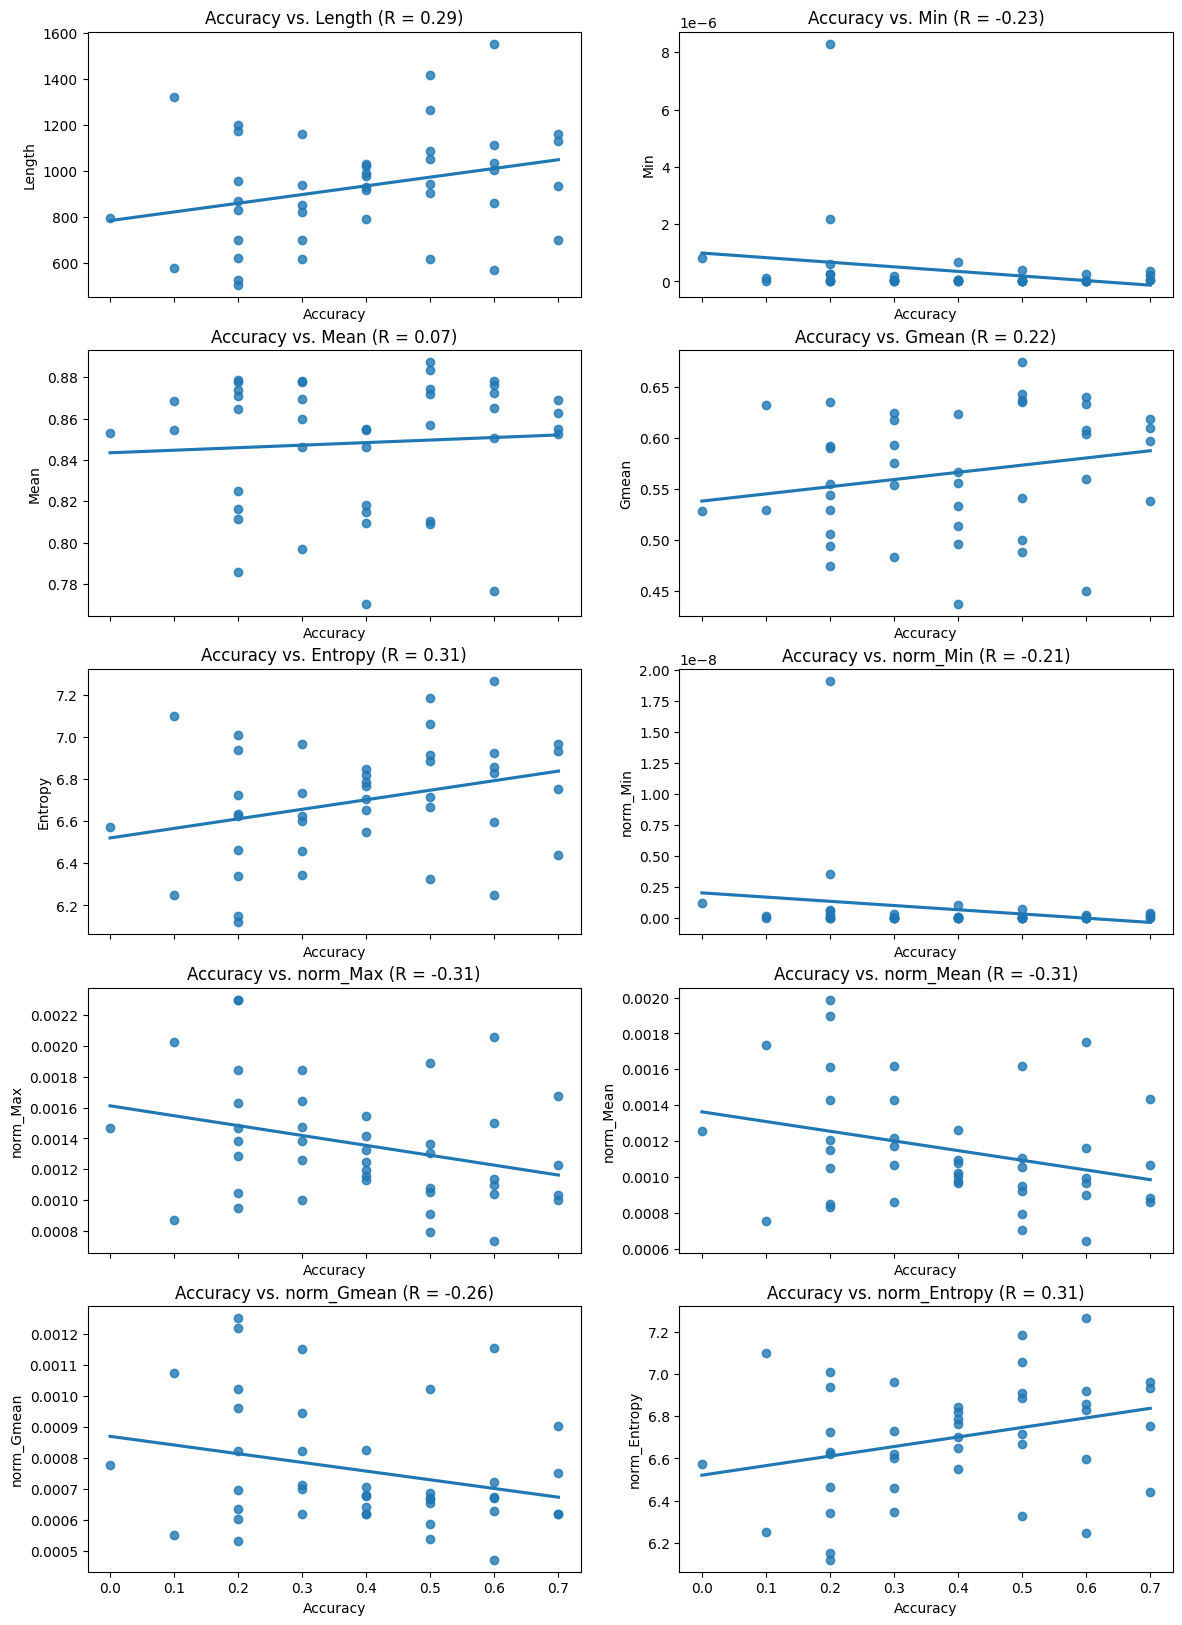

In [97]:
fig, ax = plt.subplots(5, 2, sharex=True, figsize=(14, 20))
for i, (label, y) in enumerate(
    [
        ("Length", Shape),
        ("Min", Min),
        # ("Max", Max),
        ("Mean", Mean),
        ("Gmean", Gmean),
        ("Entropy", Entropy),
        ("norm_Min", norm_Min),
        ("norm_Max", norm_Max),
        ("norm_Mean", norm_Mean),
        ("norm_Gmean", norm_Gmean),
        ("norm_Entropy", norm_Entropy),
    ]
):
    sct = sns.regplot(x=np.array(accuracies), y=np.array(y), ci=None, ax=ax[i//2,i%2])
    pears = pearsonr(x=np.array(accuracies), y=np.array(y))
    sct.set(xlabel="Accuracy", ylabel=label, title=f"Accuracy vs. {label} (R = {pears.statistic:.2f})")

In [ ]:
REVERSED
Best few shots
Question: Shawn has five toys. For Christmas, he got two toys each from his mom and dad. How many toys does he have now?
Answer: Let's think step by step. He has 5 toys. He got 2 from mom, so after that he has 5 + 2 = 7 toys. Then he got 2 more from dad, so in total he has 7 + 2 = 9 toys.
The answer is 9

Question: There are 15 trees in the grove. Grove workers will plant trees in the grove today. After they are done, there will be 21 trees. How many trees did the grove workers plant today?
Answer: Let's think step by step. We start with 15 trees. Later we have 21 trees. The difference must be the number of trees they planted. So, they must have planted 21 - 15 = 6 trees.
The answer is 6

Question: Jason had 20 lollipops. He gave Denny some lollipops. Now Jason has 12 lollipops. How many lollipops did Jason give to Denny?
Answer: Let's think step by step. Jason had 20 lollipops. Since he only has 12 now, he must have given the rest to Denny. The number of lollipops he has given to Denny must have been 20 - 12 = 8 lollipops.
The answer is 8

Question: Leah had 32 chocolates and her sister had 42. If they ate 35, how many pieces do they have left in total?
Answer: Let's think step by step. Leah had 32 chocolates and Leah's sister had 42. That means there were originally 32 + 42 = 74 chocolates. 35 have been eaten. So in total they still have 74 - 35 = 39 chocolates.
The answer is 39

Question: If there are 3 cars in the parking lot and 2 more cars arrive, how many cars are in the parking lot?
Answer: Let's think step by step. There are 3 cars in the parking lot already. 2 more arrive. Now there are 3 + 2 = 5 cars.
The answer is 5

Question: There were nine computers in the server room. Five more computers were installed each day, from monday to thursday. How many computers are now in the server room?
Answer: Let's think step by step. There are 4 days from monday to thursday. 5 computers were added each day. That means in total 4 * 5 = 20 computers were added. There were 9 computers in the beginning, so now there are 9 + 20 = 29 computers.
The answer is 29

Question: Michael had 58 golf balls. On tuesday, he lost 23 golf balls. On wednesday, he lost 2 more. How many golf balls did he have at the end of wednesday?
Answer: Let's think step by step. Michael initially had 58 balls. He lost 23 on Tuesday, so after that he has 58 - 23 = 35 balls. On Wednesday he lost 2 more so now he has 35 - 2 = 33 balls.
The answer is 33

Question: Olivia has $23. She bought five bagels for $3 each. How much money does she have left?
Answer: Let's think step by step. She bought 5 bagels for $3 each. This means she spent $15. She has $8 left.
The answer is 8


Starting optimization: 1 trials, 30 test set, 8 demonstrations, 8 training examples
accuracies = [0.7]
Shape = [888]
Min = [2.795980157482979e-08]
Mean = [0.7235636652925681]
Gmean = [0.37248620542000704]
Entropy = [6.592327581923152]
norm_Min = [4.3515539191685334e-11]
norm_Mean = [0.001126126126126126]
norm_Gmean = [0.0005797229292538391]
norm_Entropy = [6.592327581923152]

In [ ]:
Best few shots
Question: Olivia has $23. She bought five bagels for $3 each. How much money does she have left?
Answer: Let's think step by step. She bought 5 bagels for $3 each. This means she spent $15. She has $8 left.
The answer is 8

Question: Michael had 58 golf balls. On tuesday, he lost 23 golf balls. On wednesday, he lost 2 more. How many golf balls did he have at the end of wednesday?
Answer: Let's think step by step. Michael initially had 58 balls. He lost 23 on Tuesday, so after that he has 58 - 23 = 35 balls. On Wednesday he lost 2 more so now he has 35 - 2 = 33 balls.
The answer is 33

Question: There were nine computers in the server room. Five more computers were installed each day, from monday to thursday. How many computers are now in the server room?
Answer: Let's think step by step. There are 4 days from monday to thursday. 5 computers were added each day. That means in total 4 * 5 = 20 computers were added. There were 9 computers in the beginning, so now there are 9 + 20 = 29 computers.
The answer is 29

Question: If there are 3 cars in the parking lot and 2 more cars arrive, how many cars are in the parking lot?
Answer: Let's think step by step. There are 3 cars in the parking lot already. 2 more arrive. Now there are 3 + 2 = 5 cars.
The answer is 5

Question: Leah had 32 chocolates and her sister had 42. If they ate 35, how many pieces do they have left in total?
Answer: Let's think step by step. Leah had 32 chocolates and Leah's sister had 42. That means there were originally 32 + 42 = 74 chocolates. 35 have been eaten. So in total they still have 74 - 35 = 39 chocolates.
The answer is 39

Question: Jason had 20 lollipops. He gave Denny some lollipops. Now Jason has 12 lollipops. How many lollipops did Jason give to Denny?
Answer: Let's think step by step. Jason had 20 lollipops. Since he only has 12 now, he must have given the rest to Denny. The number of lollipops he has given to Denny must have been 20 - 12 = 8 lollipops.
The answer is 8

Question: There are 15 trees in the grove. Grove workers will plant trees in the grove today. After they are done, there will be 21 trees. How many trees did the grove workers plant today?
Answer: Let's think step by step. We start with 15 trees. Later we have 21 trees. The difference must be the number of trees they planted. So, they must have planted 21 - 15 = 6 trees.
The answer is 6

Question: Shawn has five toys. For Christmas, he got two toys each from his mom and dad. How many toys does he have now?
Answer: Let's think step by step. He has 5 toys. He got 2 from mom, so after that he has 5 + 2 = 7 toys. Then he got 2 more from dad, so in total he has 7 + 2 = 9 toys.
The answer is 9


Starting optimization: 1 trials, 30 test set, 8 demonstrations, 8 training examples
accuracies = [0.7]
Shape = [888]
Min = [2.5207259605786527e-08]
Mean = [0.7161778259833422]
Gmean = [0.36464682095779855]
Entropy = [6.584511830449262]
norm_Min = [3.963618054097672e-11]
norm_Mean = [0.0011261261261261261]
norm_Gmean = [0.0005733747918341222]
norm_Entropy = [6.584511830449262]

In [ ]:
shuffled from PAL
Best few shots
Question: Jason had 20 lollipops. He gave Denny some lollipops. Now Jason has 12 lollipops. How many lollipops did Jason give to Denny?
Answer: Let's think step by step. Jason had 20 lollipops. Since he only has 12 now, he must have given the rest to Denny. The number of lollipops he has given to Denny must have been 20 - 12 = 8 lollipops.
The answer is 8

Question: Michael had 58 golf balls. On tuesday, he lost 23 golf balls. On wednesday, he lost 2 more. How many golf balls did he have at the end of wednesday?
Answer: Let's think step by step. Michael initially had 58 balls. He lost 23 on Tuesday, so after that he has 58 - 23 = 35 balls. On Wednesday he lost 2 more so now he has 35 - 2 = 33 balls.
The answer is 33

Question: Shawn has five toys. For Christmas, he got two toys each from his mom and dad. How many toys does he have now?
Answer: Let's think step by step. He has 5 toys. He got 2 from mom, so after that he has 5 + 2 = 7 toys. Then he got 2 more from dad, so in total he has 7 + 2 = 9 toys.
The answer is 9

Question: Olivia has $23. She bought five bagels for $3 each. How much money does she have left?
Answer: Let's think step by step. She bought 5 bagels for $3 each. This means she spent $15. She has $8 left.
The answer is 8

Question: Leah had 32 chocolates and her sister had 42. If they ate 35, how many pieces do they have left in total?
Answer: Let's think step by step. Leah had 32 chocolates and Leah's sister had 42. That means there were originally 32 + 42 = 74 chocolates. 35 have been eaten. So in total they still have 74 - 35 = 39 chocolates.
The answer is 39

Question: If there are 3 cars in the parking lot and 2 more cars arrive, how many cars are in the parking lot?
Answer: Let's think step by step. There are 3 cars in the parking lot already. 2 more arrive. Now there are 3 + 2 = 5 cars.
The answer is 5

Question: There were nine computers in the server room. Five more computers were installed each day, from monday to thursday. How many computers are now in the server room?
Answer: Let's think step by step. There are 4 days from monday to thursday. 5 computers were added each day. That means in total 4 * 5 = 20 computers were added. There were 9 computers in the beginning, so now there are 9 + 20 = 29 computers.
The answer is 29

Question: There are 15 trees in the grove. Grove workers will plant trees in the grove today. After they are done, there will be 21 trees. How many trees did the grove workers plant today?
Answer: Let's think step by step. We start with 15 trees. Later we have 21 trees. The difference must be the number of trees they planted. So, they must have planted 21 - 15 = 6 trees.
The answer is 6


Starting optimization: 10 trials, 30 test set, 8 demonstrations, 8 training examples
accuracies = [0.7, 0.7, 0.7, 0.8, 0.7333333333333333, 0.7666666666666667, 0.7, 0.7, 0.7666666666666667, 0.7333333333333333]
Shape = [888, 888, 888, 888, 888, 888, 888, 888, 888, 888]
Min = [3.0835254884007364e-08, 1.7310674196374018e-08, 1.7310674196374018e-08, 5.4417105371561505e-08, 2.5207259605786527e-08, 2.372211592009424e-08, 3.2903236461716883e-07, 2.2235074245144013e-07, 5.4417105371561505e-08, 1.7310674196374018e-08]
Mean = [0.7216540054755203, 0.7133331674001636, 0.7117721367164799, 0.7176032187031386, 0.7125136979869148, 0.7213395838126926, 0.7206829454253229, 0.7220134933089145, 0.7128936555129561, 0.7127838335311358]
Gmean = [0.3778752946485591, 0.3567929696574198, 0.361512221324039, 0.3643536241804912, 0.3698280289176631, 0.38408695426294626, 0.3719315654601079, 0.3763808614198027, 0.368207212701019, 0.3665241135165111]
Entropy = [6.592313682950887, 6.581538600264022, 6.581797848545432, 6.586913117071376, 6.584180378235163, 6.59441477893695, 6.589360228492893, 6.592792122296737, 6.584139065628094, 6.5831503781213785]
norm_Min = [4.8117776478990017e-11, 2.7328047207509803e-11, 2.7387982006886576e-11, 8.539611092857232e-11, 3.984001106269437e-11, 3.703400604110945e-11, 5.141400174493874e-10, 3.468009705616075e-10, 8.596026012179884e-11, 2.734910860256292e-11]
norm_Mean = [0.0011261261261261261, 0.0011261261261261261, 0.0011261261261261261, 0.0011261261261261261, 0.0011261261261261261, 0.0011261261261261263, 0.0011261261261261261, 0.001126126126126126, 0.0011261261261261261, 0.001126126126126126]
norm_Gmean = [0.0005896665694260947, 0.0005632625862803174, 0.0005719644480956329, 0.000571775773358299, 0.0005845122791527834, 0.0005996209879590175, 0.0005811735322089943, 0.0005870421056485035, 0.0005816404155712979, 0.0005790709057490601]
norm_Entropy = [6.592313682950887, 6.581538600264022, 6.581797848545432, 6.586913117071376, 6.584180378235163, 6.594414778936949, 6.589360228492893, 6.592792122296737, 6.584139065628094, 6.583150378121379]

In [ ]:
shuffled gsm8k
Starting optimization: 10 trials, 30 test set, 8 demonstrations, 7,473 training examples
accuracies = [0.6333333333333333, 0.43333333333333335, 0.7333333333333333, 0.5666666666666667, 0.6333333333333333, 0.5666666666666667, 0.6333333333333333, 0.5333333333333333, 0.6, 0.5666666666666667]
Shape = [1623, 2254, 1541, 1805, 1544, 1662, 1512, 1570, 2212, 1770]
Min = [1.0206341422145351e-07, 4.381810818754194e-07, 3.4480206519943566e-08, 2.6218404484172127e-06, 1.0429269094086867e-06, 1.4085348094965428e-08, 2.6110060701664957e-08, 2.2798818822130465e-07, 1.3031838299627522e-06, 1.503595960936941e-08]
Mean = [0.874126904839436, 0.852272312468705, 0.8588136394599848, 0.8517576588070579, 0.8626237366777657, 0.8742136913746946, 0.8749359769119941, 0.8662004524621512, 0.880556206636822, 0.8734054853901362]
Gmean = [0.6521426980395976, 0.6113789624593203, 0.6279471795416119, 0.5984678139172822, 0.623621030092971, 0.6608140874557642, 0.6439819186316572, 0.6667598136760152, 0.6803008484430209, 0.6425243206413604]
Entropy = [7.310384088991409, 7.627417301832118, 7.252046439239527, 7.400862535993973, 7.251107277813283, 7.337731666937417, 7.2401722827629635, 7.280327167939586, 7.627651165922543, 7.400521927866462]
norm_Min = [7.194110178244324e-11, 2.2809792352734146e-10, 2.6053632714849798e-11, 1.7053479586588736e-09, 7.830422089364235e-10, 9.694355932553872e-12, 1.9736939754232205e-11, 1.6764642190801713e-10, 6.690575522971459e-10, 9.72617252441167e-12]
norm_Mean = [0.0006161429451632779, 0.0004436557231588287, 0.0006489292667099288, 0.000554016620498615, 0.0006476683937823834, 0.000601684717208183, 0.0006613756613756613, 0.0006369426751592356, 0.0004520795660036166, 0.0005649717514124294]
norm_Gmean = [0.00045967367027863204, 0.0003182571717345849, 0.0004744839672187032, 0.00038926696145946075, 0.0004682222546353457, 0.00045481069589836746, 0.0004867944382081578, 0.0004902881061817862, 0.00034926800810440416, 0.000415623781657016]
norm_Entropy = [7.310384088991409, 7.62741730183212, 7.2520464392395265, 7.400862535993973, 7.251107277813283, 7.337731666937415, 7.2401722827629635, 7.280327167939586, 7.627651165922543, 7.400521927866462]